In [ ]:
# Author: Brandon Botzer
# Date: 3/19/2024
# Class: Penn State - AI 879

Tasks:

Problem:

    Take at least three pictures of your own in a panorama style and stitch them together in one panoramic image. Use the algorithm in 12.2 (use either SIFT or SURF feature) and then add RANSAC to trim the matching features. Compare the result with/without RANSAC triming. Python user could check this link as reference: https://scikit-learn.org/stable/auto_examples/linear_model/plot_ransac.html



In [1]:
# Imports for functions

from PIL import Image

import skimage as ski
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches
import cv2 as cv


# Showing the results of scipy computations
import pandas as pd

cv.__version__, ski.__version__

('4.8.1', '0.22.0')

# Read in the three images

In [31]:
# Read in the images
im1 = ski.io.imread('Library1.jpg')
im2 = ski.io.imread('Library2.jpg')
im3 = ski.io.imread('Library3.jpg')

# Convert these to grayscale knowing the SIFT needs grayscale
im1 = ski.color.rgb2gray(im1)
im2 = ski.color.rgb2gray(im2)
im3 = ski.color.rgb2gray(im3)

# For some reason these get rotated from my phone
im1 = ski.transform.rotate(im1, -90)
im2 = ski.transform.rotate(im2, -90)
im3 = ski.transform.rotate(im3, -90)

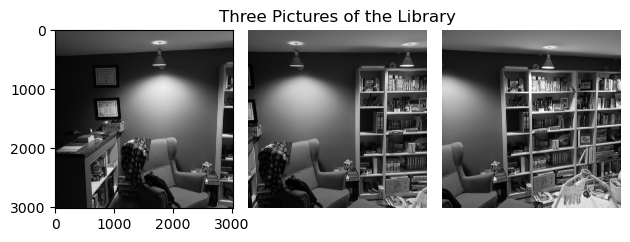

In [32]:
# Showing the pictures to be stitched
fig, axs = plt.subplots(1,3)

axs[0].imshow(im1, cmap='gray')
# axs[0].axis('off')
axs[1].imshow(im2, cmap='gray')
axs[1].axis('off')
axs[2].imshow(im3, cmap='gray')
axs[2].axis('off')

axs[1].set_title('Three Pictures of the Library 3072x3072')

plt.tight_layout()

There is a good chance that the images I take with my phone camera are going to be a very high resolution.  This will cause issues for my machine when running the SIFT algorithm.  To address this, I'll resize the images using skimage and use a Gaussian filter to smooth the images and reduce aliasing.

In [33]:
# Declare an image size
resize_shape = (400, 400)

# The order=3 corresponds to a bi-cubic interpolation
# The anti_aliasing=True applies the Gaussian Filter
im1 = ski.transform.resize(im1, resize_shape, order=3, anti_aliasing=True)
im2 = ski.transform.resize(im2, resize_shape, order=3, anti_aliasing=True)
im3 = ski.transform.resize(im3, resize_shape, order=3, anti_aliasing=True)

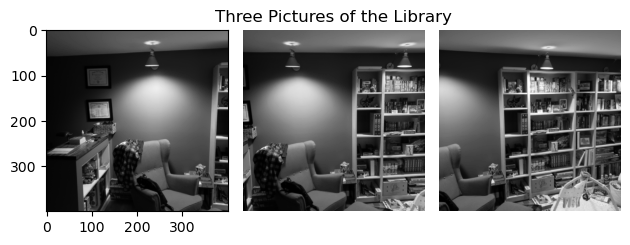

In [34]:
# Showing the resized pictures to be stitched
fig, axs = plt.subplots(1,3)

axs[0].imshow(im1, cmap='gray')
# axs[0].axis('off')
axs[1].imshow(im2, cmap='gray')
axs[1].axis('off')
axs[2].imshow(im3, cmap='gray')
axs[2].axis('off')

axs[1].set_title('Three Pictures of the Library Resized (400x400)')

plt.tight_layout()

# The SIFT Function

In [35]:
# Bring in a modified applySIFT() function from what I built from Lesson 7 Homework

# Using skimage functions
def applySIFT(im1, im2, every_n_element=30, plot=False, title=''):

    '''
    Apply the SIFT Feature Extractor to an image and the same image that has been transformed.
    These found points are then matched between the two images and the matches are plotted.

    WARNING: This is crashing my machine for high-resolution images... Make sure you rescale!

    Args:
        im1: The first image

        im2: The second image which will be compared to the first.

        every_n_element: Given the many SIFT features that are found, this shows every n'th element

        title: plot title

    Returns:
        matches: the matching points between the two images as determined by SIFT
    '''

    # Change a color image to grayscale
    if len(im1.shape) > 2:
        im1 = ski.color.rgb2gray(im1)
    if len(im2.shape) > 2:
        im2 = ski.color.rgb2gray(im2)

    # Built the descriptor object.
        # This object will do the detecting and extracting of the features
        # The default SIFT parameters need 51GB of RAM to operate on the images.
        # I am decreasing the number of octaves to run.
    descriptor_extractor_SFIT = ski.feature.SIFT(n_octaves=3, n_scales=2)

    # Find and extract the features for im1
    descriptor_extractor_SFIT.detect_and_extract(im1)
    keypoints_im1 = descriptor_extractor_SFIT.keypoints
    descriptors_im1 = descriptor_extractor_SFIT.descriptors

    # Find and extract the features for im2
    descriptor_extractor_SFIT.detect_and_extract(im2)
    keypoints_im2 = descriptor_extractor_SFIT.keypoints
    descriptors_im2 = descriptor_extractor_SFIT.descriptors

    # Match the descriptors from each image as per:
        # https://scikit-image.org/docs/stable/api/skimage.feature.html#skimage.feature.SIFT
        # A descriptor is given by: (N, n_hist*n_hist*n_ori) array
    matches = ski.feature.match_descriptors(descriptors_im1, descriptors_im2, cross_check=True, max_ratio=0.8)

    if plot:
        # Plot the two images with their matched peaks
        fig, ax = plt.subplots(nrows=1, ncols=1)
        plt.gray()
        plt.title(title)
        ski.feature.plot_matches(ax, im1, im2, keypoints_im1, keypoints_im2, matches[::every_n_element], only_matches=True)

    return matches

# Applying SIFT (Testing as of 3/19/24 - BB)

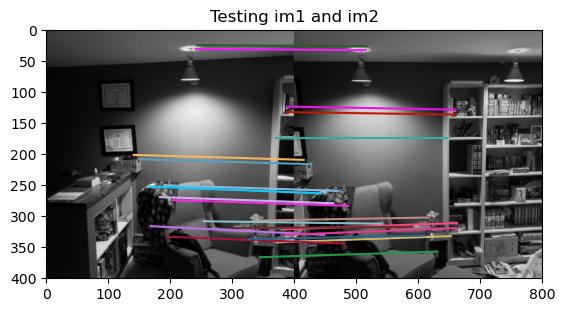

In [44]:
# Match im1 and im2
matches_12 = applySIFT(im1, im2, every_n_element=10, plot=True, title='Testing im1 and im2')

In [45]:
# What is the size of the matches?
matches_12.shape

(201, 2)

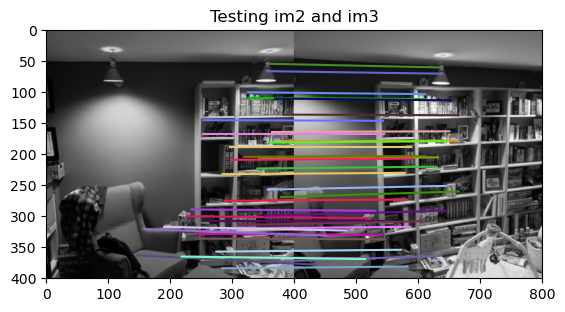

In [46]:
# Match im2 and im3
matches_23 = applySIFT(im2, im3, every_n_element=10, plot=True, title='Testing im2 and im3')

In [47]:
# What is the size of the matches?
matches_23.shape

(358, 2)

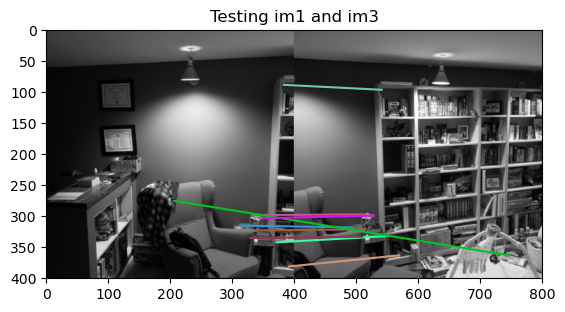

In [48]:
# Match im1 and im3
matches_13 = applySIFT(im1, im3, every_n_element=10, plot=True, title='Testing im1 and im3')

In [49]:
# What is the size of the matches?
matches_13.shape

(90, 2)

I still need to apply RANSAC and to create a way to iterate over the SIFTS rather than running them as one offs (though I may be fine to do that for the purposes to get it work first).